Saturation curves for SM-omics and ST<br>

Input files are generated by counting number of unique molecules and number of annotated reads per annotated region after adjusting for sequencing depth, in downsampled fastq files (proportions 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1) processed using ST-pipeline.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_genes_after_seq_depth_in_spots_under_tissue.txt<br>
10005CN48_genes_after_seq_depth_in_spots_under_tissue.txt<br>
10005CN48_genes_after_seq_depth_in_spots_under_tissue.txt<br>
10015CN60_genes_after_seq_depth_in_spots_under_tissue.txt<br>
10015CN84_genes_after_seq_depth_in_spots_under_tissue.txt<br>
10015CN84_genes_after_seq_depth_in_spots_under_tissue.txt<br>

In [1]:
%matplotlib inline
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glob
import warnings
from mlxtend.evaluate import permutation_test
from scipy.stats import ranksums, ttest_ind
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')

In [2]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['Name'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
    
    elif row['Name'] in ['10005CN48_C1','10005CN48_D1','10005CN48_E1']:
        return condition[1]
    

In [12]:
# Load input files
path = '../../smomics_data'

stats_list = []

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
spots_under_tissue = {'10005CN48_C1':258,
              '10005CN48_D1':252,
               '10005CN48_E1':203,
              '10015CN84_D2': 201,
              '10015CN84_C2': 241,
            '10015CN60_E2':235}
    
for filename in samples_list:
    
    cond_file = pd.read_csv(os.path.join(path, filename + '_genes_after_seq_depth_in_spots_under_tissue.txt'), sep = '\t')
    if numpy.unique(cond_file['Name']) == '10005CN60_E2':
        cond_file['Name'] = '10015CN60_E2'
    cond_file['Condition'] = cond_file.apply(lambda row: condition(row), axis = 1)

    stats_list.append(cond_file)

# Concat all files
cond_merge = pd.concat(stats_list)
    

In [13]:
cond_file

,Name,Genes,Num reads,Condition
0,10015CN60_E2,3713.757246,20412525,sm-omics
1,10015CN60_E2,3189.873188,13980500,sm-omics
2,10015CN60_E2,1641.199275,4332462,sm-omics
3,10015CN60_E2,4070.181159,26844551,sm-omics
4,10015CN60_E2,2342.286232,7548475,sm-omics
5,10015CN60_E2,1136.423913,2724456,sm-omics
6,10015CN60_E2,616.141304,1438051,sm-omics
7,10015CN60_E2,4337.318841,33276576,sm-omics
8,10015CN60_E2,481.985507,1148609,sm-omics


In [21]:
prop_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

cond_list = []
for label, df in cond_merge.groupby(['Condition', 'Name']):
    
    # Sort df by annotated reads
   
    df.sort_values(by='Num reads', inplace=True)
    
    df['Prop_annot_reads'] = prop_list
        
    cond_list.append(df)
    
# Concatenate all dfs in list
plot_df_tmp = pd.concat(cond_list)

# Remove 'unknown' regions, if any
plot_df_big = plot_df_tmp
plot_df_big_max = plot_df_tmp[plot_df_tmp['Prop_annot_reads'] == 1.000]

In [23]:
numpy.unique(plot_df_tmp['Name'])

array(['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN60_E2',
       '10015CN84_C2', '10015CN84_D2'], dtype=object)

In [27]:
# Prepare samples for plotting
ll = []

for label, df in plot_df_big.groupby(['Name']):
    # Get max annotated reads
    max_annot = df['Num reads'].max()
    
    # Get tot number of uniq mol at that amount of annotated reads
    tot_uniq_mol = df[df['Num reads'] == max_annot]['Genes'].sum()
       
    df['Prop_uniq_mol'] = df['Genes'] / tot_uniq_mol
    ll.append(df)

# Concatenate all dfs in list
prop_df = pd.concat(ll)
plot_dict = {}

# # Get a df per annotated region
# for label, df in prop_df.groupby(['Annotated_region']):
        
#     #df.drop(['Num reads', 'Annotated_reads', 'Unique_molecules'], axis=1, inplace=True)

#     plot_dict[label] = df

plot_dict_all = {}
    
for label in ['sm-omics', 'ST']:
    df = plot_df_big[plot_df_big['Condition'] == label]
    df = df.groupby(['Condition', 'Name', 'Prop_annot_reads']).sum()    
    df['Prop_annot_reads'] = list(df.index.get_level_values(2))
    df['Condition'] = list(df.index.get_level_values(0))
    plot_dict_all[label] = df

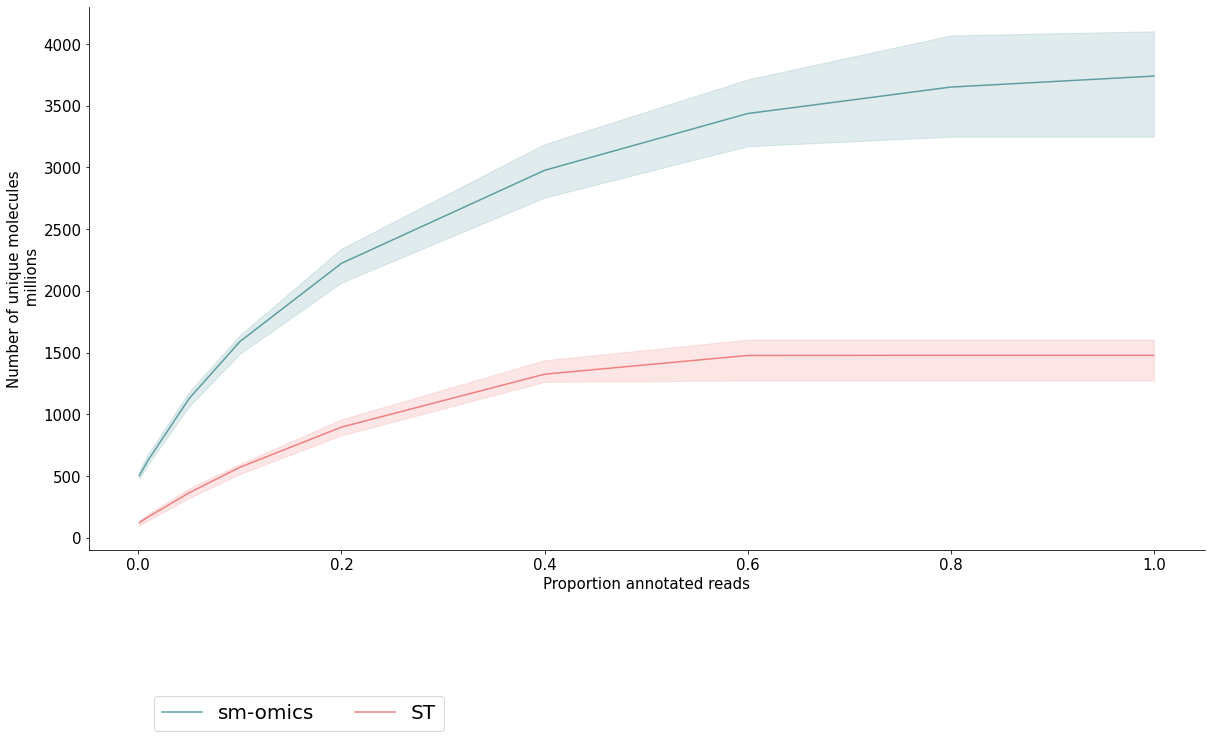

In [31]:
#Plot 
fig = plt.figure(figsize=(5, 5)) 

x="Prop_annot_reads"
y="Genes"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=95

################ LINE PLOT
count = 0
for key, value in plot_dict_all.items():
    
    #print(key)
    #print(value)
    
    ax = sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, hue_order=hue_order, )
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    ax.set_xlabel("Proportion annotated reads", fontsize=15)
    ax.set_ylabel("Number of unique molecules\n millions", fontsize=15)
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    

# LEGEND
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)
        
fig.set_size_inches(20, 10)
# plt.savefig("../../figures/genes_saturation_total_sm_st.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)
plt.show()

In [34]:
plot_df_big['Prop_annot_reads'] = 100*plot_df_big['Prop_annot_reads']

In [41]:
plot_df_big.to_csv('../../smomics_data/sm_st_genes.csv')

In [40]:
plot_df_big

,Name,Genes,Num reads,Condition,Prop_annot_reads
2,10005CN48_C1,125.924188,1148609,ST,0.1
7,10005CN48_C1,172.119134,1438051,ST,1.0
3,10005CN48_C1,371.841155,2724456,ST,5.0
4,10005CN48_C1,598.425993,4332462,ST,10.0
8,10005CN48_C1,958.790614,7548475,ST,20.0
1,10005CN48_C1,1438.158845,13980500,ST,40.0
5,10005CN48_C1,1605.209386,20412525,ST,60.0
0,10005CN48_C1,1605.209386,26844551,ST,80.0
6,10005CN48_C1,1605.209386,33276576,ST,100.0
2,10005CN48_D1,99.044444,1148609,ST,0.1
